# III. Plotting time-series with NRT Package

---

We can now start analyzing the VI time-series with the NRT package. The objective is to fully understand how this tool works, by visualizing through plots the time-series values, the modeling by harmonious function and the more or less early detections depending on the methods used.

---
## 0. Install NRT package (optional)

Depending of your Python environment, you can install the NRT Package in different ways. Here, we choose to install the package in our current session (uncomment the line of code if necessary).

In [1]:
#!pip install nrt

---

## 1. Import librairies
First, we import some basic librairies.

In [19]:
import os
import pickle

Here are imported all detection methods avalaible in the NRT package:
- **EWMA**: Exponentially Weighted Moving Average
- **IQR**: InterQuantile Range
- **CCDC**: Continuous Change Detection and Classification of land cover
- **CuSum**: Cumulative Sum of Residual
- **MoSum**: Moving Sum of Residuals

In [20]:
from nrt.monitor.ewma import EWMA
from nrt.monitor.iqr import IQR
from nrt.monitor.ccdc import CCDC
from nrt.monitor.cusum import CuSum
from nrt.monitor.mosum import MoSum

We also import the spatial librairies

In [21]:
import datetime as dt
import geopandas as gpd
import xarray as xr
import numpy as np

... And an add-on to the NRT package, available only in this tutorial. It allows you to easily compare, through plots, the detections carried out by the different methods with reference data.

In [22]:
from nrt_plot import Nrt_plot

---

## 2. Loading samples and VI time-series

### 2.1. Point samples

We visually interpreted some points in the sentinel time series, noting the probable date of appearance of the yellow or red stage of bark beetle dieback (the initial stage, called green, is impossible to estimate on "natural color" compositions ). This information is saved in the vector file `plot01_samples.shp`.

Below an illustration of these points superimposed on a recent image from Google Maps:

<img src="img/sampling_points.png" alt="drawing" width="1000"/>

For each point, we have the following information:
- `chgt_int`: index
- `SAMPLE_1`: date in UNIX format (nb of days from 01/01/1970)
- `date_mon`: date in YYYY-MM-DD
- `geometry`: geometry in epsg:3035

In [23]:
# open samples
vector = gpd.read_file(r"data_ref/plot01_samples.shp")
vector

,id,chgt_int,SAMPLE_1,date_mon,geometry
0,None,1,17917,2019-01-21,POINT (3954485.331 2912697.966)
1,None,2,17992,2019-04-06,POINT (3954538.339 2912799.742)
2,None,3,18062,2019-06-15,POINT (3954562.723 2912844.268)
3,None,4,18087,2019-07-10,POINT (3954531.978 2912881.374)
4,None,5,18149,2019-09-10,POINT (3954475.790 2912926.961)
5,None,6,18159,2019-09-20,POINT (3954604.069 2912906.818)
6,None,7,18234,2019-12-04,POINT (3954613.611 2912943.924)
7,None,8,18249,2019-12-19,POINT (3954683.581 2912967.247)
8,None,9,18299,2020-02-07,POINT (3954830.944 2912876.073)
9,None,10,18337,2020-03-16,POINT (3954905.155 2912856.990)


### 2.2. Loading VI time-series

In this example, we test two types of dataset:
- vi-mask: complete VI time-series with cloud masks applied
- vi-nocloud: partial VI time-series (cloudy images are removed)

In [24]:
with open('nrt_var.txt', 'rb') as f:
    dict_var = pickle.load(f)

startdate = dict_var['startdate']
enddate = dict_var['enddate']
output_dir = dict_var['output_dir']

In [25]:
vi_mask = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-mask.nc')
    )
vi_nocloud = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-nocloud.nc')
    )

We get the 3 vegetation indices of vi_mask.

In [26]:
ndvi = vi_mask.ndvi
ndmi = vi_mask.ndmi
crswir = vi_mask.crswir

## 3. Tests NRT implemented methods
### 3.1. Test 01: IQR method

In [27]:
# Instanciation
IqrMon = IQR(
    trend=False,
    harmonic_order=2,
    sensitivity=3,
    boundary=3
)

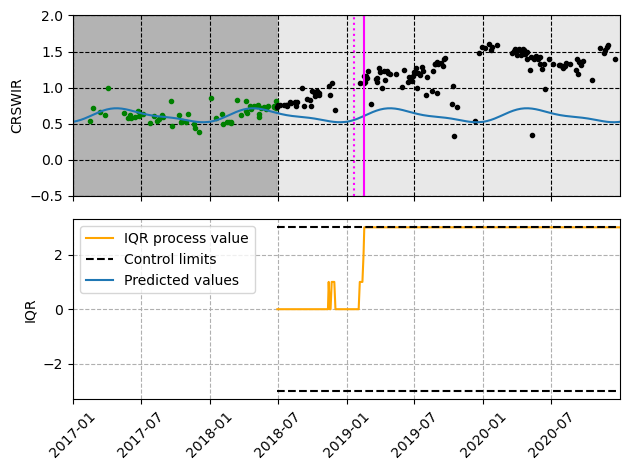

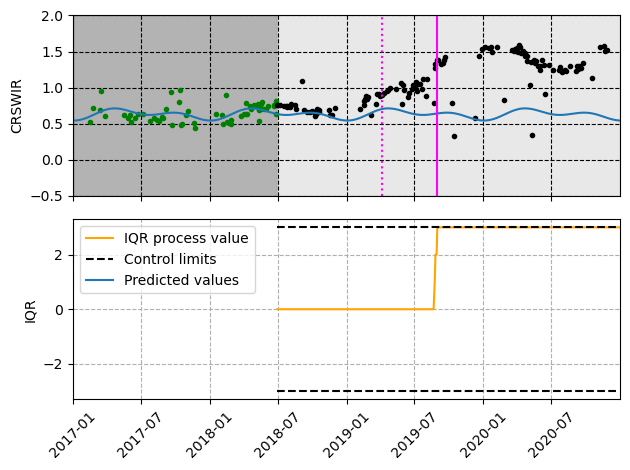

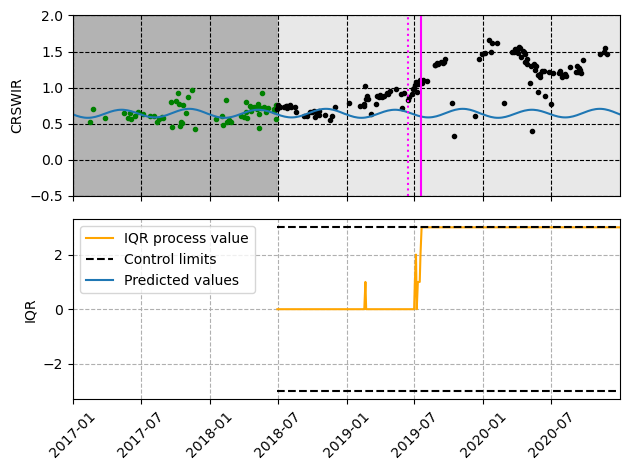

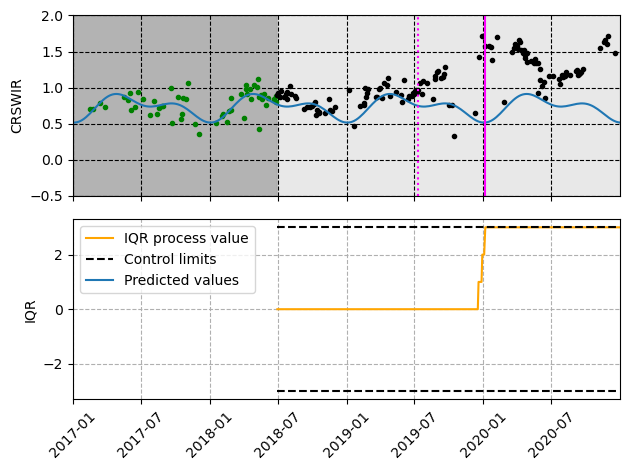

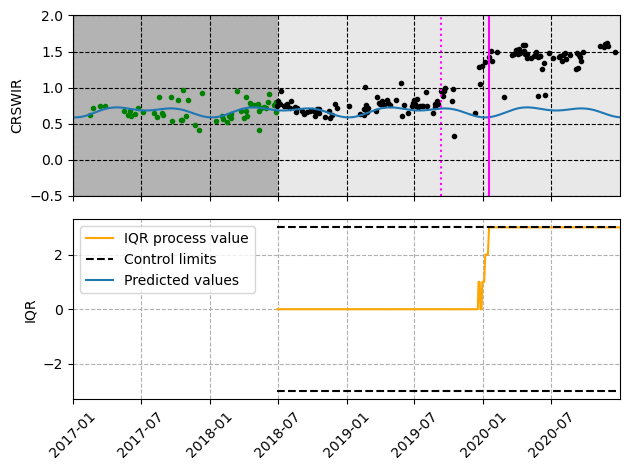

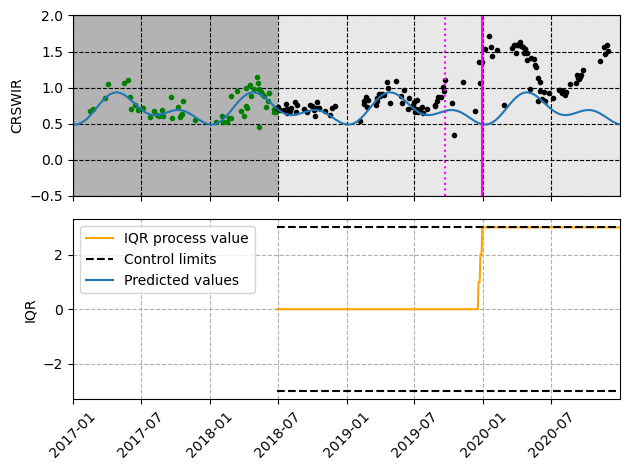

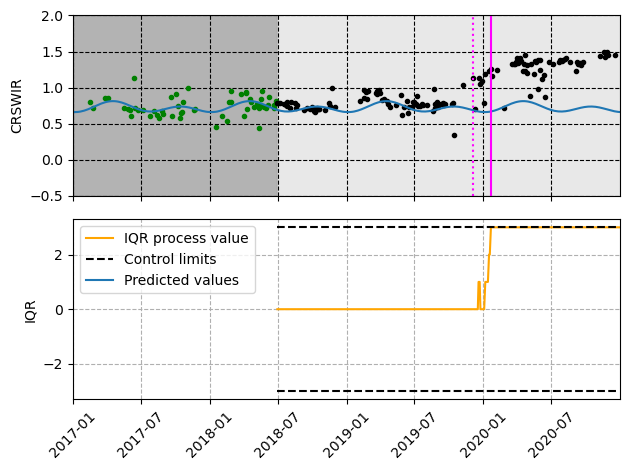

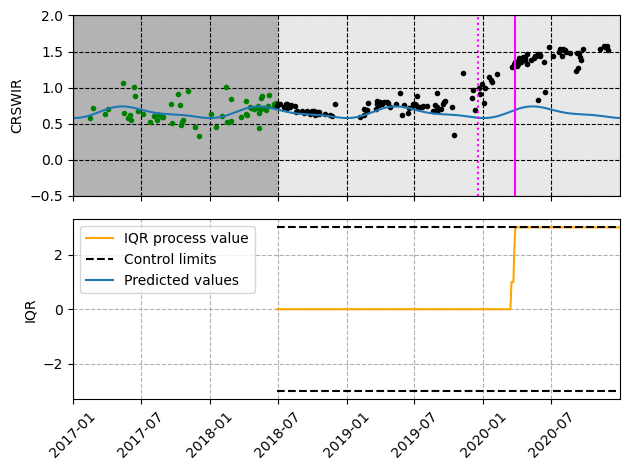

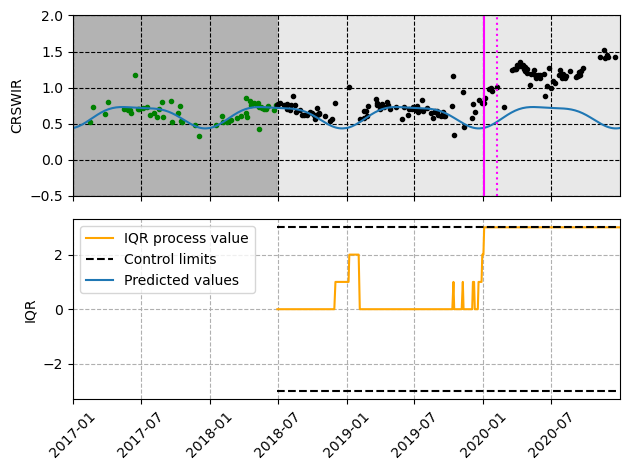

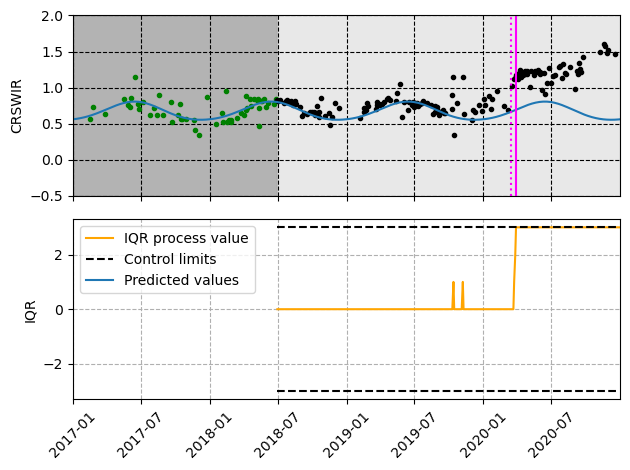

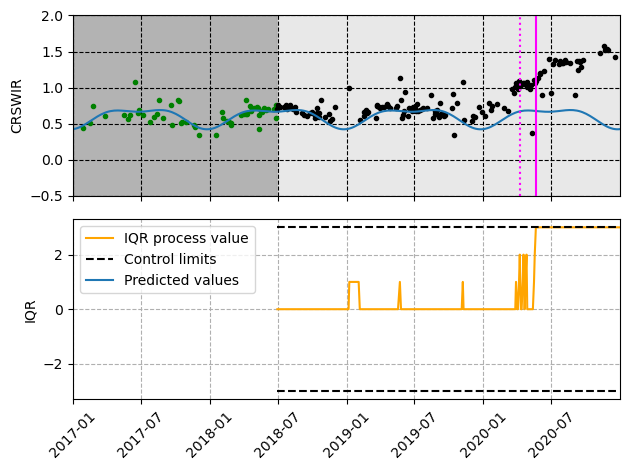

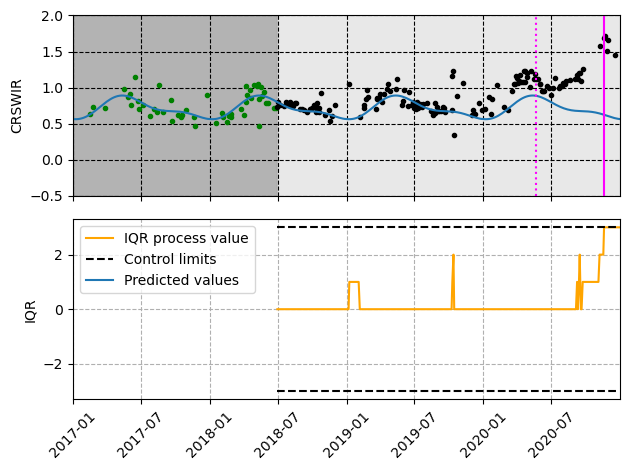

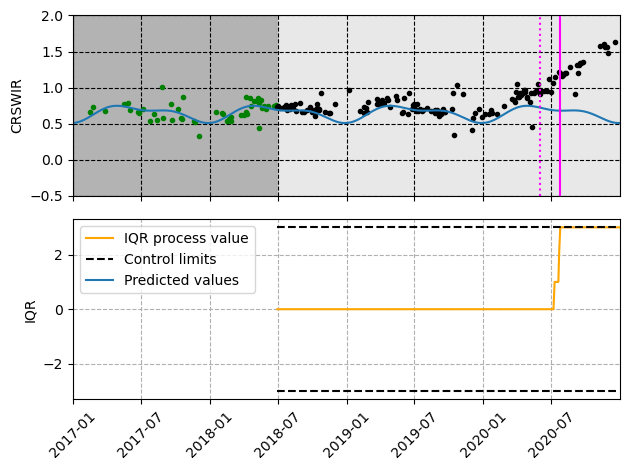

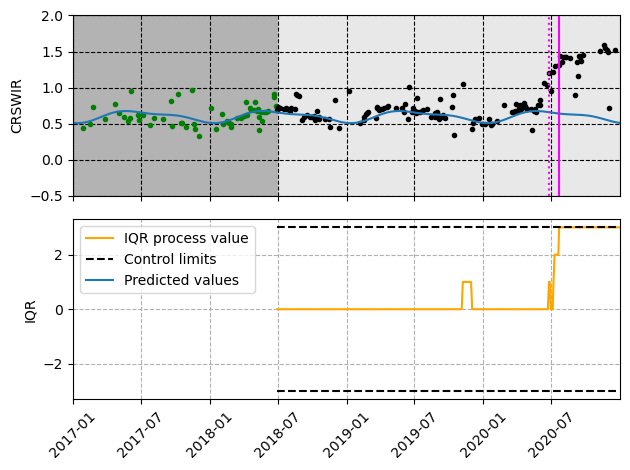

In [28]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2018, 6, 30)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(IqrMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'IQR', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)

    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

Brief assessment:

In [29]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

number of days between reference and detection:
---
-mean:79.64285714285714
-min: 12
-max: 182
false negatives:0


### 3.2. Test 02: EWMA method

In [ ]:
# Instantiation 
EwmaMon = EWMA(trend=False,
               harmonic_order=2,
               sensitivity=7,
               threshold_outlier=1, #100,
               lambda_=1,
              )

In [ ]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2018, 6, 30)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(EwmaMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'EWMA', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

Brief assessment:

In [ ]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

### 3.3. Test 03: CUSUM method

In [ ]:
# Instantiation 
CusumMon = CuSum(trend=False,
               harmonic_order=2,
               sensitivity=8,
               #lambda_=0.1, 
               #threshold_outlier=2
              )

In [ ]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2018, 6, 30)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(CusumMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'CuSum', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

Brief assessment:

In [ ]:
# Assessment based on absolute difference
if len(list_diff) > 0:
    abs_diff = [np.abs(i) for i in list_diff]
    diff_mean = np.mean(abs_diff)
    diff_max = np.max(abs_diff)
    diff_min = np.min(abs_diff)

    print("number of days between reference and detection:\n---")
    print(f"-mean:{diff_mean}\n-min: {diff_min}\n-max: {diff_max}")
    print(f"false negatives:{list_none}")

### 3.4. Test 04: MoSum method

In [ ]:
# Instanciation
MosumMon = MoSum(
    trend=False,
    harmonic_order=2,
    sensitivity=3
    #alpha=0.03
)

In [ ]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2018, 6, 30)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']
    my_plot = Nrt_plot(MosumMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'MoSum', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y]
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')

### 3.5. Test 05: CCDC method

In [ ]:
# Instanciation
CcdcMon = CCDC(
    trend=False,
    harmonic_order=2,
    sensitivity=3,
    boundary=3
)

In [ ]:
array = xr.open_dataset(
    f'data/S2TS_2017-01-2022-12.nc'
    )


In [ ]:
# period dates (yyyy, mm, dd)
d1 = dt.datetime(2017, 1, 1)
d2 = dt.datetime(2019, 1, 1)
d3 = dt.datetime(2020, 12, 31)

list_diff = list()
list_none = 0
for i in range(len(vector)):
    pt = vector.iloc[i]
    pt_x = pt['geometry'].x
    pt_y = pt['geometry'].y
    pt_date = pt['SAMPLE_1']

    # --- for ccdc only ---
    green = array.B03.sel(x=[pt_x], y=[pt_y],
                                   method='nearest')
    swir = array.B11.sel(x=[pt_x], y=[pt_y],
                                   method='nearest')

    cloud_mask = array.SCL.isin([3, 8, 9, 10])

    green_mask = green.where(~cloud_mask)
    swir_mask = swir.where(~cloud_mask)
    
    print(green_mask.dims)
    #green = green.astype(np.int16)
    #swir = swir.astype(np.int16)

    # --- end ---

    my_plot = Nrt_plot(CcdcMon, crswir, [d1, d2], [d2, d3],
                       'CRSWIR', 'CCDC', ylim=[-0.5, 2],
                       coords=[pt_x, pt_y], green=green_mask, swir=swir_mask
                      )

    my_plot.plot_predict()
    my_plot.plot_break()
    my_plot.plot_date(pt_date)
    my_plot.plot_model()
    # get break date
    monitor_date = my_plot.break_dt
    if monitor_date == 0:
        list_none += 1
    else:
        diff = monitor_date - pt_date
        list_diff.append(diff)
    my_plot.show()

# for saving graph as image file:
# my_plot.savefig('<path>/my_plot.png')
